# VLLE

Following the approach described in Bell et al.: https://doi.org/10.1021/acs.iecr.1c04703

for the mixture of nitrogen + ethane, with the default thermodynamic model in teqp, which is the GERG-2008 mixing parameters (no departure function).

Two traces are made, and the intersection is obtained, this gives you the VLLE solution.

In [1]:
import teqp, numpy as np, matplotlib.pyplot as plt, pandas

def get_traces(*, T, ipures):
    names = ['Nitrogen', 'Ethane']
    model = teqp.build_multifluid_model(names, teqp.get_datapath())
    pures = [teqp.build_multifluid_model([name], teqp.get_datapath()) for name in names]
    traces = []
    for ipure in ipures:
        # Init at the pure fluid endpoint
        anc = pures[ipure].build_ancillaries()
        rhoLpure, rhoVpure = pures[ipure].pure_VLE_T(T, anc.rhoL(T), anc.rhoV(T), 10)

        rhovecL = np.array([0.0, 0.0])
        rhovecV = np.array([0.0, 0.0])
        rhovecL[ipure] = rhoLpure
        rhovecV[ipure] = rhoVpure
        opt = teqp.TVLEOptions()
        opt.p_termination = 1e8 
        opt.crit_termination=1e-4
        opt.calc_criticality=True
        j = model.trace_VLE_isotherm_binary(T, rhovecL, rhovecV, opt)
        traces.append(j)
    return model, traces

rhovec / mol/m^3 | p / Pa
[3.66984834e+03 3.25893958e+00] 2321103.0873191245
[19890.16767481  1698.86505766] 2321103.0873192116
[ 5641.24690517 16140.85769908] 2321103.087318882


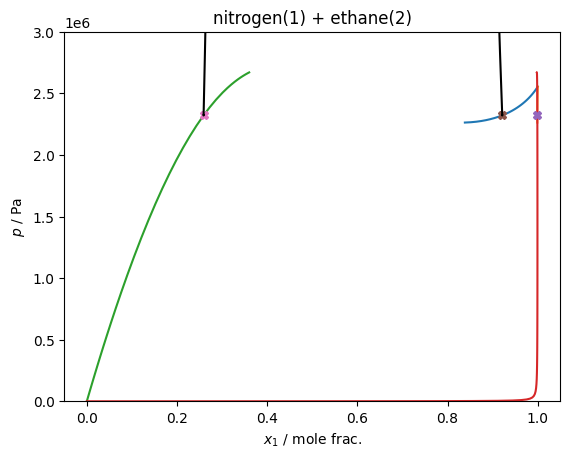

In [2]:
T = 120.3420
model, traces = get_traces(T=T, ipures=[0,1])
for trace in traces:
    df = pandas.DataFrame(trace)
    plt.plot(df['xL_0 / mole frac.'], df['pL / Pa'])
    plt.plot(df['xV_0 / mole frac.'], df['pV / Pa'])
    
# Do the VLLE solving
for soln in model.find_VLLE_T_binary(traces):
    print('rhovec / mol/m^3 | p / Pa')
    for rhovec in soln['polished']:
        rhovec = np.array(rhovec)
        rhotot = sum(rhovec)
        x = rhovec/rhotot
        p = rhotot*model.get_R(x)*T*(1+model.get_Ar01(T, rhotot, x))
        plt.plot(x[0], p, 'X')
        print(rhovec, p)
        
    # And also carry out the LLE trace for the two liquid phases
    j = model.trace_VLE_isotherm_binary(T, np.array(soln['polished'][1]), np.array(soln['polished'][2]))
    df = pandas.DataFrame(j)
    plt.plot(df['xL_0 / mole frac.'], df['pL / Pa'], 'k')
    plt.plot(df['xV_0 / mole frac.'], df['pV / Pa'], 'k')

# Plotting niceties
plt.ylim(top=3e6, bottom=0)
plt.gca().set(xlabel='$x_1$ / mole frac.', ylabel='$p$ / Pa', title='nitrogen(1) + ethane(2)')
plt.show()

Calculated pressure is not finite


Text(0.5, 1.0, 'Nitrogen + ethane VLLE curve')

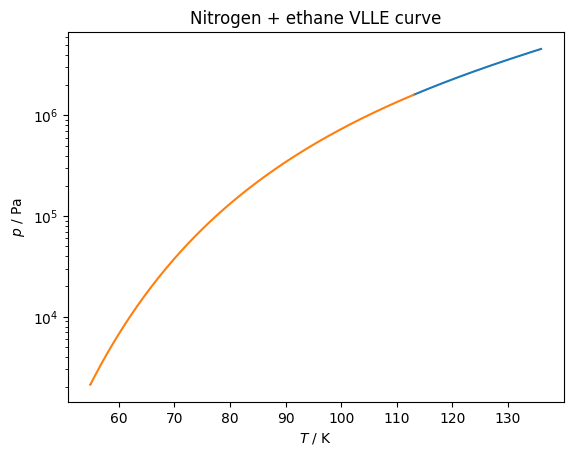

In [3]:
T = 113.0
model, traces = get_traces(T=T, ipures = [0,1])

# Find the VLLE solution for the starting temperature
solns = model.find_VLLE_T_binary(traces)
rhovecV, rhovecL1, rhovecL2 = solns[0]['polished']

# Trace towards lower and higher temperatures
for init_dT in [1.0e-3, -1.0e-3]:

    opt = teqp.VLLETracerOptions()
    opt.init_dT = init_dT
    opt.T_limit = -1 if init_dT < 0 else 10000
    opt.verbosity = 100
    a = lambda x: np.array(x)
    VLLE = model.trace_VLLE_binary(T, a(rhovecV), a(rhovecL1), a(rhovecL2), opt)
    df = pandas.DataFrame(VLLE)
    if df.empty:
        raise ValueError('No results')

    # Add the pressure to the DataFrame
    def add_ps(row, key):
        T = row['T / K']
        rhovec = np.array(row[key])
        rhotot = sum(rhovec)
        x = rhovec/rhotot
        p = rhotot*model.get_R(x)*T*(1+model.get_Ar01(T, rhotot, x))
        return p
    df['p / Pa']  = df.apply(add_ps, axis=1, key='rhoV / mol/m^3')

    # Plot the p-T curve
    plt.plot(df['T / K'], df['p / Pa'])
    
plt.gca().set(xlabel='$T$ / K', ylabel='$p$ / Pa', yscale='log')
plt.title('Nitrogen + ethane VLLE curve')